# 1. Albedo optimization

## Overview

In this tutorial, we will build a simple example application that showcases differentiation and optimization of a light transport simulation involving the well-known Cornell Box scene. We are going to optimize the color of one of the walls of the Cornell Box to match a target image.

Mitsuba’s ability to automatically differentiate entire rendering algorithms builds on differentiable JIT array types provided by the Enoki library. Those are explained in the [Enoki documentation](...). The linked document also discusses key differences compared to superficially similar frameworks like PyTorch and TensorFlow. For *automatic differentiation* (AD), Enoki records and simplifies computation graphs and uses them to propagate derivatives in forward or reverse mode. Before getting further into this tutorial, we recommend that you familiarize yourself this document.

<div class="alert alert-block alert-info">

✔️ **What will you learn?**
    
<ul>
  <li>Passing scene arguments when loading an XML file</li>
  <li>Build an optimization pipeline using the optimizer classes</li>
  <li>Perform gradient-based optimization using automatic differentiation</li>
</ul>
    
</div>


### Step 1 - setup

In order to use the automatic differentiation, we need to enable a variant that supports it. Those are the ones containing `_ad` after the backend description. E.g. `cuda_ad_rgb`, `llvm_ad_rgb`, ... 

In [1]:
# Add mitsuba and enoki to PATH (this shouldn't be necessary)
import sys
sys.path.append('../../../build/python')

In [2]:
from matplotlib import pyplot as plt

import enoki as ek 
import mitsuba
mitsuba.set_variant('cuda_ad_rgb')

It is possible to pass arguments directly to the scene via the `load_file` rountine.

In [3]:
from mitsuba.core import load_file
from mitsuba.python.util import traverse

# TODO would be great no to have to do this!
ek.set_flag(ek.JitFlag.LoopRecord,  False)

scene = load_file('../scenes/cbox.xml', res=128, max_depth=3)
params = traverse(scene)

2021-12-09 07:58:10 INFO main [xml.cpp:1250] Loading XML file "../scenes/cbox.xml" ..

2021-12-09 07:58:10 INFO main [xml.cpp:1251] Using variant "cuda_ad_rgb"

2021-12-09 07:58:10 INFO main [Scene] Building scene in OptiX ..

2021-12-09 07:58:10 INFO main [Scene] OptiX ready. (took 43ms)

As we enabled a differentiable variant, when printing `params` you will notice the asterisk (`*`) on the left of some parameters which indicates that they are differentiable.

``` python
print(params)

# Output
SceneParameters[
    ...
    redwall.to_world,
  * redwall.bsdf.reflectance.value,
    redwall.vertex_count,
    redwall.face_count,
    redwall.faces,
  * redwall.vertex_positions,
  * redwall.vertex_normals,
  * redwall.vertex_texcoords,
    ...
]
```

### Step 2 - reference image

Our first experiment is going to be very simple: we will change the color of the red wall and then try to recover the original color using differentiation along with the reference image generated above. 

Before starting the optimization process, let's generate a reference image that will be used by the objective function. In contrast to the previous tutorial using `mitsuba.python.util.render` to render images, the differentiable rendering pipeline  involves another rendering function `mitsuba.python.autodiff.render` that is more optimized for this use case as it directly returns a JIT array containing the generated image. As we will soon discover, this function also takes arguments related to differential rendering.

The `mitsuba.python.autodiff` submodule also provides a helper function to reshapes the output into an image of the correct size and exports it to any of the supported image formats (OpenEXR, PNG, JPG, RGBE, PFM) while automatically performing format conversion and gamma correction in the case of an 8-bit output format. The `write_async` argument can be used to performed this task asynchronously which is really handy when one wants to write images during the optimization process.

In [4]:
from mitsuba.python.util import write_bitmap, convert_to_bitmap

integrator = scene.integrator()
image_ref = integrator.render(scene, seed=0, spp=8)
write_bitmap('out_ref.png', image_ref)

2021-12-09 07:58:10 INFO main [SamplingIntegrator] Starting render job (128x128, 8 samples)

2021-12-09 07:58:11 INFO main [SamplingIntegrator] Rendering finished. (took 828ms)

It is also possible to convert the data iamge to a `mitsuba.core.Bitmap` object and display it using `matplotlib.

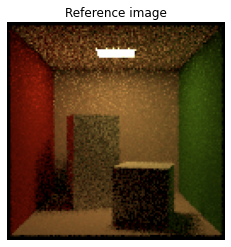

In [5]:
def show_image(img, title):
    plt.imshow(convert_to_bitmap(img)); plt.axis('off'); plt.title(title);
    plt.show()
    
show_image(image_ref, 'Reference image')

Let’s make a backup copy of this color value for later use and set it's value to a blue-ish color. As always, it is important not to forget to call `params.update()` to inform changed scene objects that they should refresh their internal state. 

This will be our initial state for the optimization process, which we can render and display to attest the difference.

2021-12-09 07:58:11 INFO main [SamplingIntegrator] Starting render job (128x128, 8 samples)

2021-12-09 07:58:12 INFO main [SamplingIntegrator] Rendering finished. (took 838ms)

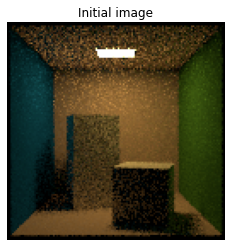

In [6]:
from mitsuba.core import Color3f

key = 'redwall.bsdf.reflectance.value'

params.keep([key])
param_ref = Color3f(params[key])

params[key] = Color3f(0.01, 0.2, 0.9)
params.update()

image_init = integrator.render(scene, seed=0, spp=8)
show_image(image_init, 'Initial image')
write_bitmap('out_init.png', image_init)

TODO talk about `Optimizer`...

In most cases, we will only be interested in differentiating a small subset of the (typically very large) parameters in the scene graph. It is responsability of the user to specify which parameters should be optimized and this can be done using the `load` method, which support list of keys and regular expressions as input argument to specify more than one parameter at a time.

In [7]:
from mitsuba.core import Thread, LogLevel
from mitsuba.python.ad.optimizers import Adam

opt = Adam(lr=0.05, params=params)
opt.load(key)
opt.update()

In [9]:
Thread.thread().logger().set_log_level(LogLevel.Warn)

errors = []
for it in range(50):    
    # Perform a differentiable rendering of the scene
    # TODO: render separately to do unbiased=True
    image = integrator.render(scene, seed=it, spp=1)

    #write_bitmap('out_%03i.png' % it, image)
    
    # Objective: MSE between 'image' and 'image_ref'
    ob_val = ek.hsum_async(ek.sqr(image - image_ref)) / len(image)

    # Back-propagate errors to input parameters
    ek.backward(ob_val)

    # Optimizer: take a gradient step
    opt.step()
    
    opt[key] = ek.clamp(opt[key], 0.0, 1.0)
    
    # Optimizer: Update the scene parameters
    opt.update()
        
    err_ref = ek.hsum(ek.sqr(param_ref - params[key]))
    print('Iteration %03i: error=%g' % (it, err_ref[0]))
    errors.append(err_ref)
    
print('Optimization complete!')

Iteration 000: error=0.920911
Iteration 001: error=0.786454
Iteration 002: error=0.667754
Iteration 003: error=0.563072
Iteration 004: error=0.470634
Iteration 005: error=0.387602
Iteration 006: error=0.314621
Iteration 007: error=0.250737
Iteration 008: error=0.196632
Iteration 009: error=0.151549
Iteration 010: error=0.114757
Iteration 011: error=0.0855981
Iteration 012: error=0.0630966
Iteration 013: error=0.0455998
Iteration 014: error=0.0317226
Iteration 015: error=0.0209985
Iteration 016: error=0.0131911
Iteration 017: error=0.00830927
Iteration 018: error=0.0058131
Iteration 019: error=0.00520093
Iteration 020: error=0.00694565
Iteration 021: error=0.0109171
Iteration 022: error=0.0144153
Iteration 023: error=0.019147
Iteration 024: error=0.0246811
Iteration 025: error=0.0305402
Iteration 026: error=0.0357669
Iteration 027: error=0.0414772
Iteration 028: error=0.0458333
Iteration 029: error=0.0487575
Iteration 030: error=0.0509495
Iteration 031: error=0.052547
Iteration 032: err

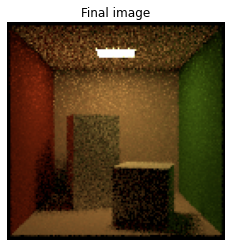

In [10]:
image_final = integrator.render(scene, seed=0, spp=8)
show_image(image_final, 'Final image')
write_bitmap('out_final.png', image_final)

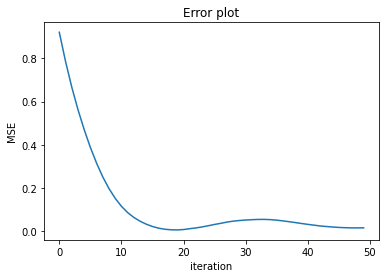

In [11]:
plt.plot(errors)
plt.xlabel('iteration'); plt.ylabel('MSE'); plt.title('Error plot');
plt.show()

### *Reference API*

- [<code>mitsuba.core.load_file</code>](https://mitsuba2.readthedocs.io/en/latest/generated/core_api.html#mitsuba.core.load_file)